In [1]:
import pandas as pd
import pybamm
import pybop

In [53]:
# parameter_set = pybamm.ParameterValues("ECM_Example")

parameter_set = pybop.ParameterSet(parameter_set="ECM_Example")
# parameter_set = pybop.ParameterSet(json_path="../initial_ecm.json")
parameter_set.update(
    {
        # "chemistry": "ecm",
        "Cell capacity [A.h]": 4.85,
        "Nominal cell capacity [A.h]": 4.85,
        # "Current function [A]": 5,
        "Initial SoC": 1,
        "Element-1 initial overpotential [V]": 0,
        "Upper voltage cut-off [V]": 4.2,
        "Lower voltage cut-off [V]": 2.5,
        "R0 [Ohm]": 1e-3,
        "R1 [Ohm]": 2e-4,
        "C1 [F]": 1e4,
        "Open-circuit voltage [V]": pybop.empirical.Thevenin().default_parameter_values[
            "Open-circuit voltage [V]"
        ],
    }
)
# Optional arguments - only needed for two RC pairs
parameter_set.update(
    {
        "R2 [Ohm]": 0.0003,
        "C2 [F]": 40000,
        "Element-2 initial overpotential [V]": 0,
    },
    check_already_exists=False,
)

In [54]:
model = pybop.empirical.Thevenin(
    parameter_set=parameter_set,
    options={"number of rc elements": 2},
    solver=pybamm.CasadiSolver(mode="safe", dt_max=10),
)

file_loc = r"../hppc_lut/G1/battery_G1_cycle_1_pulse_1_lut.csv"
df = pd.read_csv(file_loc, index_col=None, na_values=["NA"])
df = df.drop_duplicates(subset=["Time"], keep="first")

dataset = pybop.Dataset(
    {
        "Time [s]": df["Time"].to_numpy(),
        "Current function [A]": df["Current"].to_numpy(), 
        "Voltage [V]": df["Voltage"].to_numpy(),
    }
)

In [55]:
r_guess = 0.005
parameters = pybop.Parameters(
    pybop.Parameter(
        "R0 [Ohm]",
        prior=pybop.Gaussian(r_guess, r_guess / 10),
        bounds=[0, 0.5],
    ),
    pybop.Parameter(
        "R1 [Ohm]",
        prior=pybop.Gaussian(r_guess, r_guess / 10),
        bounds=[0, 0.5],
    ),
    pybop.Parameter(
        "R2 [Ohm]",
        prior=pybop.Gaussian(r_guess, r_guess / 10),
        bounds=[0, 0.5],
    ),
    pybop.Parameter(
        "C1 [F]",
        prior=pybop.Gaussian(500, 100),
        bounds=[1, 2000],
    ),
    pybop.Parameter(
        "C2 [F]",
        prior=pybop.Gaussian(2000, 500),
        bounds=[0, 2000],
    ),
)

In [56]:
initial_state_of_charge= df["SoC"].iloc[0] 

model.build(
    # initial_state={"Initial open-circuit voltage [V]": df["Voltage"].to_numpy()[0]}
    initial_state={"Initial SoC": initial_state_of_charge} # soc scales between 0 to 1
)
problem = pybop.FittingProblem(
    model,
    parameters,
    dataset,
)

cost = pybop.SumSquaredError(problem)

In [57]:
optim = pybop.PSO(
    cost,
    sigma0=[1e-3, 1e-3, 1e-3, 50, 500],
    max_unchanged_iterations=30,
    max_iterations=100,
)
results = optim.run()

# Export the parameters to JSON only works with the pybop.ParameterSet
parameter_set.export_parameters(
    "fit_ecm_parameters.json", fit_params=parameters
)

Halt: No significant change for 30 iterations.
OptimisationResult:
  Best result from 1 run(s).
  Initial parameters: [5.63241247e-03 4.87035035e-03 5.04957550e-03 5.53382784e+02
 1.99980000e+03]
  Optimised parameters: [3.03546721e-02 3.13193845e-03 8.63643388e-03 3.34781276e+02
 1.94333896e+03]
  Total-order sensitivities:
  Diagonal Fisher Information entries: None
  Final cost: 0.4276767872904478
  Optimisation time: 101.85865950584412 seconds
  Number of iterations: 66
  Number of evaluations: 385
  SciPy result available: No
  PyBaMM Solution available: Yes


In [58]:
pybop.plot.quick(problem, problem_inputs=results.x, title="Optimised Comparison");

In [59]:
pybop.plot.convergence(optim)
pybop.plot.parameters(optim);

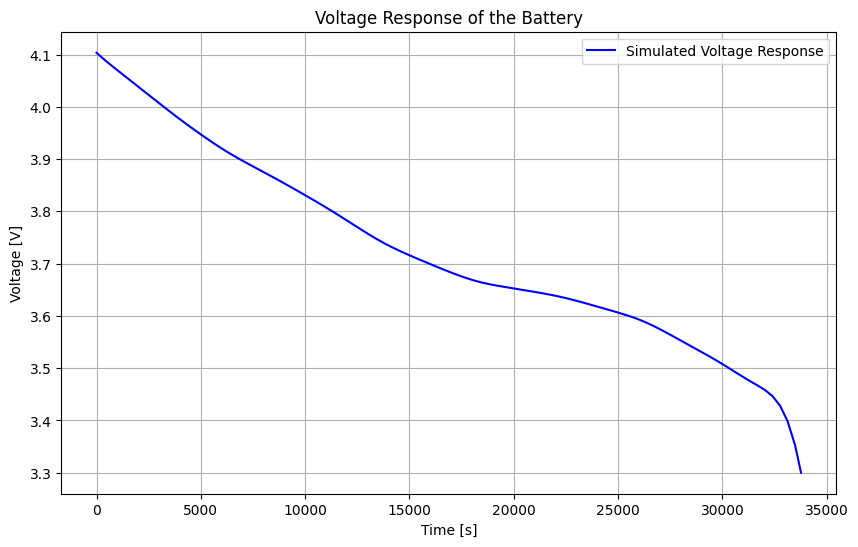

In [60]:
import os
import pandas as pd
import matplotlib.pyplot as plt

experiment = pybamm.Experiment(
    [
        (
            "Discharge at C/10 for 10 hours or until 3.3 V"
        ),
    ]
)

sol = model.predict(
    inputs=results.x,
    experiment=experiment,
    initial_state={"Initial SoC": 0.95},
)

voltage_response = sol["Voltage [V]"].entries  
time_points = sol["Time [s]"].entries

# Plot the voltage response
plt.figure(figsize=(10, 6))
plt.plot(time_points, voltage_response, label="Simulated Voltage Response", color='blue')
plt.xlabel("Time [s]")
plt.ylabel("Voltage [V]")
plt.title("Voltage Response of the Battery")
plt.legend()
plt.grid(True)
plt.show()


## save model to a pickle file to save parameter values

In [61]:
import json

# print out the models categories and type of data
# i dont believe i need to save this as, well we only really need the RC pairs
parameter_info = model.get_parameter_info()
print(parameter_info)

custom_parameter_set = {
    "R0 [Ohm]": sol["R0 [Ohm]"].entries[0],
    "R1 [Ohm]": sol["R1 [Ohm]"].entries[0],
    "R2 [Ohm]": sol["R2 [Ohm]"].entries[0],
    "C1 [F]": sol["C1 [F]"].entries[0],
    "C2 [F]": sol["C2 [F]"].entries[0],
    "Open-circuit voltage [V]": sol["Open-circuit voltage [V]"].entries.tolist(),
    "Entropic change [V/K]": sol["Entropic change [V/K]"].entries.tolist(),
}

file_loc = "data\\pkl\\G1"

with open(file_loc + "\\G1_cycle_1_parameter_values.json", "w") as f:
    json.dump(custom_parameter_set, f, indent=4)

{}


## Using the pickle file saved parameters with pybamm

In [220]:
import pybamm 
import json
import numpy as np
from scipy.interpolate import interp1d

# trying from the exported params
with open("fit_ecm_parameters.json", "r") as f:
    loaded_data = json.load(f)

r0_data = loaded_data["R0 [Ohm]"]
r1_data = loaded_data["R1 [Ohm]"]
c1_data = loaded_data["C1 [F]"]
entropic_change = loaded_data["Entropic change [V/K]"]

# min_ocv = np.min(loaded_data["Open-circuit voltage [V]"])
# max_ocv = np.max(loaded_data["Open-circuit voltage [V]"])

# Define a linear function for OCV as a function of SOC
# def ocv_function(soc):
#     return min_ocv + (max_ocv - min_ocv) * soc

model = pybamm.equivalent_circuit.Thevenin()
parameter_values = model.default_parameter_values
parameter_values.update({
    "R0 [Ohm]": r0_data,  
    "R1 [Ohm]": r1_data,
    "C1 [F]": c1_data,
    "Initial SoC": 1
    # "Open-circuit voltage [V]": ocv_function
})

experiment = pybamm.Experiment(
    [
        (
            "Discharge at C/10 for 6 hours or until 3.3 V",
            "Rest for 30 minutes",
            "Rest for 2 hours",
            "Charge at 100 A until 4.1 V",
            "Hold at 4.1 V until 5 A",
            "Rest for 30 minutes",
            "Rest for 1 hour",
        ),
    ]
)
solver = pybamm.CasadiSolver(mode="fast", atol=1e-6, rtol=1e-3)
sim = pybamm.Simulation(model, parameter_values=parameter_values, experiment=experiment, solver=solver)
sim.solve()
sim.plot()

interactive(children=(FloatSlider(value=0.0, description='t', max=14.451050072406835, step=0.14451050072406835…

In [217]:
import os
import pandas as pd
import pybamm
import pybop

# 298.15 K // 25 degree C
FIXED_TEMPERATURE = 298.15

# Prepare an empty list to store LUT data for each pulse
lut = []

exported_params_file_loc = "data/parameters/G1/"

# Loop over pulses 0 to 9
for pulse in range(10):
    file_loc = f"../hppc_lut/G1/battery_G1_cycle_1_pulse_{pulse}_lut.csv"
    print(f"Processing {file_loc}...")
    
    # Read and clean the CSV data
    df = pd.read_csv(file_loc, na_values=["NA"])
    df = df.drop_duplicates(subset=["Time"], keep="first")
    
    # Create the dataset for pybop
    dataset = pybop.Dataset({
        "Time [s]": df["Time"].to_numpy(),
        "Current function [A]": df["Current"].to_numpy(), 
        "Voltage [V]": df["Voltage"].to_numpy(),
    })
    
    # Update parameter set for the ECM
    # parameter_set = pybamm.ParameterValues("ECM_Example")
    parameter_set = pybop.ParameterSet(parameter_set="ECM_Example")
    parameter_set.update({
        "Initial SoC": 1.0,
        "Cell capacity [A.h]": 4.85,
        "Nominal cell capacity [A.h]": 4.85,
        "Element-1 initial overpotential [V]": 0,
        "Upper voltage cut-off [V]": 4.2,
        "Lower voltage cut-off [V]": 2.5,
        "R0 [Ohm]": 1e-3,
        "R1 [Ohm]": 2e-4,
        "C1 [F]": 1e4,
        "Open-circuit voltage [V]": pybop.empirical.Thevenin().default_parameter_values["Open-circuit voltage [V]"]
    })
    parameter_set.update({
        "R2 [Ohm]": 0.0003,
        "C2 [F]": 40000,
        "Element-2 initial overpotential [V]": 0,
    }, check_already_exists=False)
    
    # Build the ECM model
    model = pybop.empirical.Thevenin(
        parameter_set=parameter_set,
        options={"number of rc elements": 2},
        solver=pybamm.CasadiSolver(mode="safe", dt_max=10),
    )
    
    # Extract the initial SoC from the CSV file (scaled from 0 to 1)
    initial_soc = df["SoC"].iloc[0] 
    #model.build(initial_state={"Initial SoC": initial_soc})
    model.build(
        #initial_state={"Initial open-circuit voltage [V]": df["Voltage"].to_numpy()[0]}
        initial_state={"Initial SoC": initial_soc} # soc scales between 0 to 1
    )

    # Set up the parameters for the optimization
    r_guess = 0.005
    parameters = pybop.Parameters(
        pybop.Parameter("R0 [Ohm]", prior=pybop.Gaussian(r_guess, r_guess / 10), bounds=[0, 0.2]),
        pybop.Parameter("R1 [Ohm]", prior=pybop.Gaussian(r_guess, r_guess / 10), bounds=[0, 0.2]),
        pybop.Parameter("R2 [Ohm]", prior=pybop.Gaussian(r_guess, r_guess / 10), bounds=[0, 0.2]),
        pybop.Parameter("C1 [F]", prior=pybop.Gaussian(500, 100), bounds=[1, 1500]),
        pybop.Parameter("C2 [F]", prior=pybop.Gaussian(2000, 500), bounds=[0, 25000]),
    )
    
    # Define and solve the fitting problem
    problem = pybop.FittingProblem(model, parameters, dataset)
    cost = pybop.SumSquaredError(problem)
    optim = pybop.PSO(
        cost,
        sigma0=[1e-3, 1e-3, 1e-3, 50, 500],
        max_unchanged_iterations=30,
        max_iterations=100,
    )
    results = optim.run()
    parameter_set.export_parameters(exported_params_file_loc + "G1_cycle_1_ecm_parameters.json", fit_params=parameters)
    
    # The results vector (results.x) -- contains the optimized parameters in order to "parameters":
    # R0, R1, R2, C1, C2. We are interested in R0, R1, and C1.
    r0, r1, r2, c1, c2 = results.x
    
    # Create a LUT entry for the current pulse
    pulse_entry = {
        #"pulse": pulse,
        "current": df.loc[df["Current"] != 0, "Current"].iloc[0],  # First nonzero current
        "voltage": df.loc[df["Current"] == 0, "Voltage"].iloc[-1],  # Last rest voltage
        "temperature": FIXED_TEMPERATURE,
        "r0": r0,
        "r1": r1,
        "c1": c1,
        "SoC": df["SoC"][0]
    }
    lut.append(pulse_entry)

# Optionally, convert the LUT list to a DataFrame and save as CSV
lut_df = pd.DataFrame(lut)
lut_df.to_csv("ecm_lut_table.csv", index=False)
print("LUT table saved to ecm_lut_table.csv")


Processing ../hppc_lut/G1/battery_G1_cycle_1_pulse_0_lut.csv...
Halt: No significant change for 30 iterations.
OptimisationResult:
  Best result from 1 run(s).
  Initial parameters: [4.48345908e-03 4.17762122e-03 5.14909276e-03 5.02192237e+02
 1.31640134e+03]
  Optimised parameters: [3.04726226e-02 1.15669834e-02 3.69529626e-03 7.45404585e+02
 1.37318774e+02]
  Total-order sensitivities:
  Diagonal Fisher Information entries: None
  Final cost: 0.7405316671438288
  Optimisation time: 134.7215552330017 seconds
  Number of iterations: 74
  Number of evaluations: 474
  SciPy result available: No
  PyBaMM Solution available: Yes
Processing ../hppc_lut/G1/battery_G1_cycle_1_pulse_1_lut.csv...
Halt: No significant change for 30 iterations.
OptimisationResult:
  Best result from 1 run(s).
  Initial parameters: [5.69513093e-03 4.91119037e-03 4.04268759e-03 6.66781928e+02
 1.16075611e+03]
  Optimised parameters: [2.83967812e-02 9.78505980e-03 3.56162865e-03 1.24413841e+03
 5.81119382e+02]
  Tot

In [218]:
import pandas as pd

# Define the input and output file paths
input_file = 'ecm_lut_table.csv'  # Replace with your input file path
output_dir = 'data/'  # Directory where the output files will be saved

# Read the input CSV file
data = pd.read_csv(input_file)

# Extract relevant columns (r0, r1, c1, and SoC)
r0_data = data[['temperature', 'current', 'SoC', 'r0']]
r1_data = data[['temperature', 'current', 'SoC', 'r1']]
c1_data = data[['temperature', 'current', 'SoC', 'c1']]

# Save each to a new CSV file
r0_data.to_csv(f'{output_dir}r0.csv', index=False)
r1_data.to_csv(f'{output_dir}r1.csv', index=False)
c1_data.to_csv(f'{output_dir}c1.csv', index=False)

print(f"Files have been saved to {output_dir}")

Files have been saved to data/


In [225]:
import pybamm
import json
import numpy as np

# Load parameters
file_loc = "data/parameters/G1/"
with open(file_loc + "G1_cycle_1_ecm_parameters.json", "r") as f:
    loaded_data = json.load(f)
    
# Set up model and parameters
one_rc = None
two_rc = {"number of rc elements" : 2}
model = pybamm.equivalent_circuit.Thevenin(options=two_rc)
parameter_values = model.default_parameter_values
parameter_values.update(loaded_data, check_already_exists=False)

# Define experiment
experiment = pybamm.Experiment(
    [
        (
            "Discharge at C/10 for 6 hours or until 2.5 V",
            # "Rest for 30 minutes",
            # "Rest for 2 hours",
            # "Charge at 100 A until 4.1 V",
            # "Hold at 4.1 V until 10 A",
            # "Rest for 1 hour",
        ),
    ]
)
# Solve and plot
solver = pybamm.CasadiSolver(mode="fast", atol=1e-6, rtol=1e-3)
sim = pybamm.Simulation(model, parameter_values=parameter_values, solver=solver, experiment=experiment)
sim.solve()
sim.plot(output_variables=["Voltage [V]"])

interactive(children=(FloatSlider(value=0.0, description='t', max=6.0, step=0.06), Output()), _dom_classes=('w…